In [10]:
'''
(C) 2023 Renata Wong

Electronic structure problem with classical shadows, as presented in https://arxiv.org/abs/2103.07510
This code uses Qiskit as platform. 
The molecule tested is H2.
The shadow is vanilla, i.e. uses randomized basis change operations. 
'''

import time
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, execute
from qiskit_aer import QasmSimulator

from qiskit.quantum_info import SparsePauliOp

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import BravyiKitaevMapper

from qiskit.circuit.library import TwoLocal

from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA

# Estimator primitive is based on the Statevector construct = algebraic simulation
from qiskit.primitives import Estimator 
from qiskit.utils import algorithm_globals

from predicting_quantum_properties.data_acquisition_shadow import randomized_classical_shadow
from predicting_quantum_properties.prediction_shadow import estimate_exp

# taking care of deprecation issues
import qiskit_nature
qiskit_nature.settings.use_pauli_sum_op = False
import h5py
H5PY_DEFAULT_READONLY=1





driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="6-31g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

problem = driver.run()

hamiltonian = problem.hamiltonian
second_q_op = hamiltonian.second_q_op()

mapper = BravyiKitaevMapper()
bkencoded_hamiltonian = mapper.map(second_q_op)

print(bkencoded_hamiltonian)

SparsePauliOp(['IIIIIIII', 'IIIIIIIZ', 'IIIIIYYX', 'IIIIIXYY', 'IIIIIIZZ', 'IIIIZIXZ', 'IIIIIZXI', 'IIIIIZII', 'IIIIZZZI', 'IIIZIIII', 'IYYXIIII', 'IXYYIIII', 'IIZZIIII', 'ZIXZZIII', 'IZXIIIII', 'IZIIIIII', 'ZZZIZIII', 'IIIIIIZI', 'IIIIZIXI', 'IIIIIZXZ', 'IIIIIZIZ', 'IIIIZZZZ', 'IIIIIYXY', 'IIIIIXXX', 'IIIIZYZY', 'IIIIZXIX', 'IIIIIXZX', 'IIIIZXZX', 'IIIIIXIX', 'IIIIIYZY', 'IIIIZXXX', 'IIIIZYXY', 'IIIZIIIZ', 'IIIZIYYX', 'IIIZIXYY', 'IIZXIIZX', 'IIIXIIZX', 'IIZXIIIX', 'IIIXIIIX', 'IIZXZIXX', 'IIIXZIXX', 'IIZXIZYY', 'IIIXIZYY', 'IYYXIIIZ', 'IXYYIIIZ', 'IYYXIYYX', 'IXYYIYYX', 'IYYXIXYY', 'IXYYIXYY', 'ZIXXZIZX', 'IZYYIIZX', 'ZIXXZIIX', 'IZYYIIIX', 'ZIXXIIXX', 'IZYYZIXX', 'ZIXXZZYY', 'IZYYIZYY', 'IIZZIIIZ', 'IIZZIYYX', 'IIZZIXYY', 'IYYZIIZX', 'IXXIIIZX', 'IYYZIIIX', 'IXXIIIIX', 'IYYZZIXX', 'IXXIZIXX', 'IYYZIZYY', 'IXXIIZYY', 'ZIXZZIIZ', 'IZXIIIIZ', 'ZIXZZYYX', 'IZXIIYYX', 'ZIXZZXYY', 'IZXIIXYY', 'IZIIIIIZ', 'IZIIIYYX', 'IZIIIXYY', 'ZXZIZIZX', 'IXIIIIZX', 'ZXZIZIIX', 'IXIIIIIX', 'ZXZIIIXX', '

In [2]:
def process_hamiltonian(hamiltonian, derandomize = False):

    hamiltonian_observables = []
    hamiltonian_coefficients = []

    for observable in hamiltonian.paulis:
        op_list = []
        for op_index, pauli_op in enumerate(observable):
            pauli_op = str(pauli_op)
            if pauli_op == 'I' or pauli_op == 'X' or pauli_op == 'Y' or pauli_op == 'Z':
                op_list.append((pauli_op, op_index))
        hamiltonian_observables.append(op_list)
    
    hamiltonian_coefficients = hamiltonian.coeffs.real
    
    system_size = len(hamiltonian_observables[0])

    # removing all occurrences of Pauli-I, for all-Pauli-I there is an empty list left
    # these observables are needed for estimate_exp()
    observables_xyze = []

    for observable in hamiltonian_observables:
        XYZE = []
        for pauli in observable:
            if pauli[0] != 'I':
                XYZE.append(pauli)
        observables_xyze.append(XYZE)   
    
    # derandomisation procedure requires that coefficients are non-negative
    if derandomize == True:
        absolute_coefficients = [abs(coeffcient) for coeffcient in hamiltonian_coefficients]

        # removing the empty list as well
        # these observables are needed for derandomisation procedure
        observables_xyz = []
        for idx, observable in enumerate(observables_xyze):
            if observable:
                observables_xyz.append(observable)
            else:
                absolute_coefficients.pop(idx)
        
        return system_size, observables_xyze, observables_xyz, hamiltonian_coefficients, absolute_coefficients
    
    return system_size, observables_xyze, hamiltonian_coefficients



# process the Hamiltonian to obtain properly formatted data
hamiltonian_data = process_hamiltonian(bkencoded_hamiltonian, derandomize = False)
system_size, observables_xyze, hamiltonian_coefficients = hamiltonian_data

#print('HAMILTONIAN\n', observables_xyze)

In [3]:
'''
VARIATIONAL ANSATZ
Note that for molecules other than H_2 you may need to specify a different number of reps.
'''

reps = 5
ansatz = TwoLocal(num_qubits=system_size, reps=reps, rotation_blocks=['ry', 'rz'],
                entanglement_blocks='cz', skip_final_rotation_layer=False)
ansatz.decompose().draw('mpl')






def basis_change_circuit(pauli_op):

    #   Generating circuit with just the basis change operators
    #
    #       pauli_op: n-qubit Pauli operator

    basis_change = QuantumCircuit(ansatz.num_qubits, ansatz.num_qubits)

    for idx, op in enumerate(pauli_op):
        
        if op == 'X':
            basis_change.h(idx)
        if op == 'Y':
            basis_change.h(idx)
            basis_change.p(-np.pi/2, idx)
            
    return basis_change

    
    


def ground_state_energy_from_shadow(operators, params):
    
    backend = QasmSimulator(method='statevector', shots=1)
    
    pauli_op_dict = Counter(tuple(x) for x in operators)    
    

    shadow = []
    for pauli_op in pauli_op_dict:
        
        qc = ansatz.bind_parameters(params)
        qc = qc.compose(basis_change_circuit(pauli_op))                                  
        qc.measure(reversed(range(system_size)), range(system_size))                      
        
        result = execute(qc, backend, shots=pauli_op_dict[pauli_op]).result()
        counts = result.get_counts()    # given in order q0 q1 ... qn-1 after register reversal in qc.measure
        
        for count in counts:
            for _ in range(counts[count]): # number of repeated measurement values

                output_str = list(count)   
                output = [int(i) for i in output_str]
                eigenvals = [x+1 if x == 0 else x-2 for x in output]
                snapshot = [(op, eigenval) for op, eigenval in zip(pauli_op, eigenvals)]
                
                shadow.append(snapshot)
    

    expectation_value = 0.0
    for term, weight in zip(observables_xyze, hamiltonian_coefficients):
        
        sum_product, match_count = estimate_exp(shadow, term)
        
        if match_count != 0:
            expectation_value += (weight * sum_product / match_count)

    return expectation_value

In [5]:
'''
Running VQE on the Hamiltonian obtained from PySCFDriver using Statevector simulator (Estimator primitive)
'''

estimator = Estimator()
# If shots = None, it calculates the exact expectation values. Otherwise, it samples from normal distributions 
# with standard errors as standard deviations using normal distribution approximation.
estimator.set_options(shots = None)
vqe_solver = VQE(estimator, ansatz, SPSA(maxiter=3000))

calc = GroundStateEigensolver(mapper, vqe_solver)
result = calc.solve(problem)
print(result.raw_result)

{   'aux_operators_evaluated': {   'AngularMomentum': (   0.007764708324754052,
                                                          {}),
                                   'Magnetization': (   -0.0025406890587447717,
                                                        {}),
                                   'ParticleNumber': (2.001635264465879, {}),
                                   'XDipole': (0.0, {}),
                                   'YDipole': (0.0, {}),
                                   'ZDipole': (1.4152393707145512, {})},
    'cost_function_evals': 6000,
    'eigenvalue': -1.8465447205107646,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7fc9e9d0cee0>,
    'optimal_parameters': {   ParameterVectorElement(θ[85]): 4.469608360307824,
                              ParameterVectorElement(θ[86]): 3.1226948341703764,
                              ParameterVectorElement(θ[87]): 4.700285265489391,
                              Paramet

NUMBER OF RANDOM OPERATORS | AVERAGE RMSE ERROR

EXPERIMENT 0: GROUND STATE ENERGY FOUND = -2.1268350287871196
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -2.1561328079453865
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -1.8027835273505197
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.9549845674351582
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -2.065020007908686
EXPERIMENT 5: GROUND STATE ENERGY FOUND = -2.056234697449727
EXPERIMENT 6: GROUND STATE ENERGY FOUND = -1.9549966153901852
EXPERIMENT 7: GROUND STATE ENERGY FOUND = -2.129524101350521
EXPERIMENT 8: GROUND STATE ENERGY FOUND = -2.078050166464991
EXPERIMENT 9: GROUND STATE ENERGY FOUND = -2.3626822585446896
50 | 0.2629857209075652
EXPERIMENT 0: GROUND STATE ENERGY FOUND = -1.8850512142828642
EXPERIMENT 1: GROUND STATE ENERGY FOUND = -2.395675832568719
EXPERIMENT 2: GROUND STATE ENERGY FOUND = -2.0607600467338294
EXPERIMENT 3: GROUND STATE ENERGY FOUND = -1.7305492413754038
EXPERIMENT 4: GROUND STATE ENERGY FOUND = -2.0912874758060456
EX

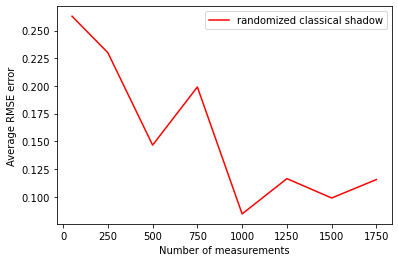

In [9]:
'''
EXPERIMENTS
'''

start_time = time.time()
rmse_errors = []




print('NUMBER OF RANDOM OPERATORS | AVERAGE RMSE ERROR\n')
measurement_range = [50, 250, 500, 750, 1000, 1250, 1500, 1750]

for num_operators in measurement_range:   
    
    randomized_basis_change = randomized_classical_shadow(num_operators, system_size)

    tuples = (tuple(pauli) for pauli in randomized_basis_change)
    counts = Counter(tuples)
    
    expectation_values = []
    num_experiments = 10


    for iteration in range(num_experiments):
        
        expectation_value = ground_state_energy_from_shadow(randomized_basis_change, result.raw_result.optimal_point)
        expectation_values.append(expectation_value)
                
        print("EXPERIMENT {}: GROUND STATE ENERGY FOUND = {}".format(iteration, expectation_value))


    rmse_randomised_cs = np.sqrt(np.sum([(expectation_values[i] - result.raw_result.optimal_value)**2 
                                           for i in range(num_experiments)])/num_experiments)

    rmse_errors.append(rmse_randomised_cs)
    
    print('{} | {}'.format(num_operators, rmse_randomised_cs))


elapsed_time = time.time() - start_time
print("Execution time = ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

          
points = measurement_range
num_points = len(measurement_range)

plt.plot([i for i in points], [rmse_errors[i] for i in range(num_points)], 'r', label='randomized classical shadow')
plt.xlabel('Number of measurements')
plt.ylabel('Average RMSE error')
plt.legend(loc=1)